In [27]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Исходные данные

In [28]:
# Фиксация генератора случайных чисел
random_seed = 1964    # 1902 1906
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
A_complex_max = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2000 + 1700j, 1500 + 1200j]
# A_complex_max = [600 + 200j, 240 + 170j, 700 + 320j, 800 + 300j, 400 + 150j]

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.01
k_b = 0.05

# Относительный размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [29]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_complex_reg_acc.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4
0,0.04+0.02j,0.035+0.015j,0.03+0.02j,0.020+0.012j,0.016+0.010j


In [30]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_complex_reg_1.xlsx').astype(complex)
df_complex

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,400.551003+150.206626j,198.309353+99.154677j,450.976315+200.433918j,604.769973+251.987489j,200.179627+100.089814j,39.491479+51.681451j
1,404.555551+151.708332j,202.231387+101.115694j,455.748484+202.554882j,610.383972+254.326655j,203.047404+101.523702j,41.062879+53.745167j
2,409.498203+153.561826j,206.468286+103.234143j,458.061881+203.583058j,619.980687+258.325286j,202.497154+101.248577j,38.755485+50.721141j
3,410.464119+153.924045j,206.471537+103.235769j,463.702654+206.090068j,626.817637+261.174015j,205.170384+102.585192j,42.162467+55.185575j
4,413.355916+155.008468j,207.056153+103.528077j,469.752997+208.779110j,630.087949+262.536645j,203.485288+101.742644j,41.762503+54.640837j
...,...,...,...,...,...,...
95,813.187665+304.945374j,413.080081+206.540040j,914.629324+406.501922j,1193.708233+497.378430j,434.451853+217.225927j,79.883679+104.620703j
96,821.994064+308.247774j,414.487860+207.243930j,930.778947+413.679532j,1186.914628+494.547762j,439.240190+219.620095j,77.726522+101.809238j
97,822.664343+308.499129j,420.805697+210.402848j,943.381340+419.280596j,1189.353666+495.564028j,445.422660+222.711330j,77.078618+100.999084j
98,832.029027+312.010885j,427.866796+213.933398j,951.331564+422.814028j,1214.309393+505.962247j,443.085808+221.542904j,80.871598+105.968838j


3. Попарные графики рассеяния модулей значений переменных датасета

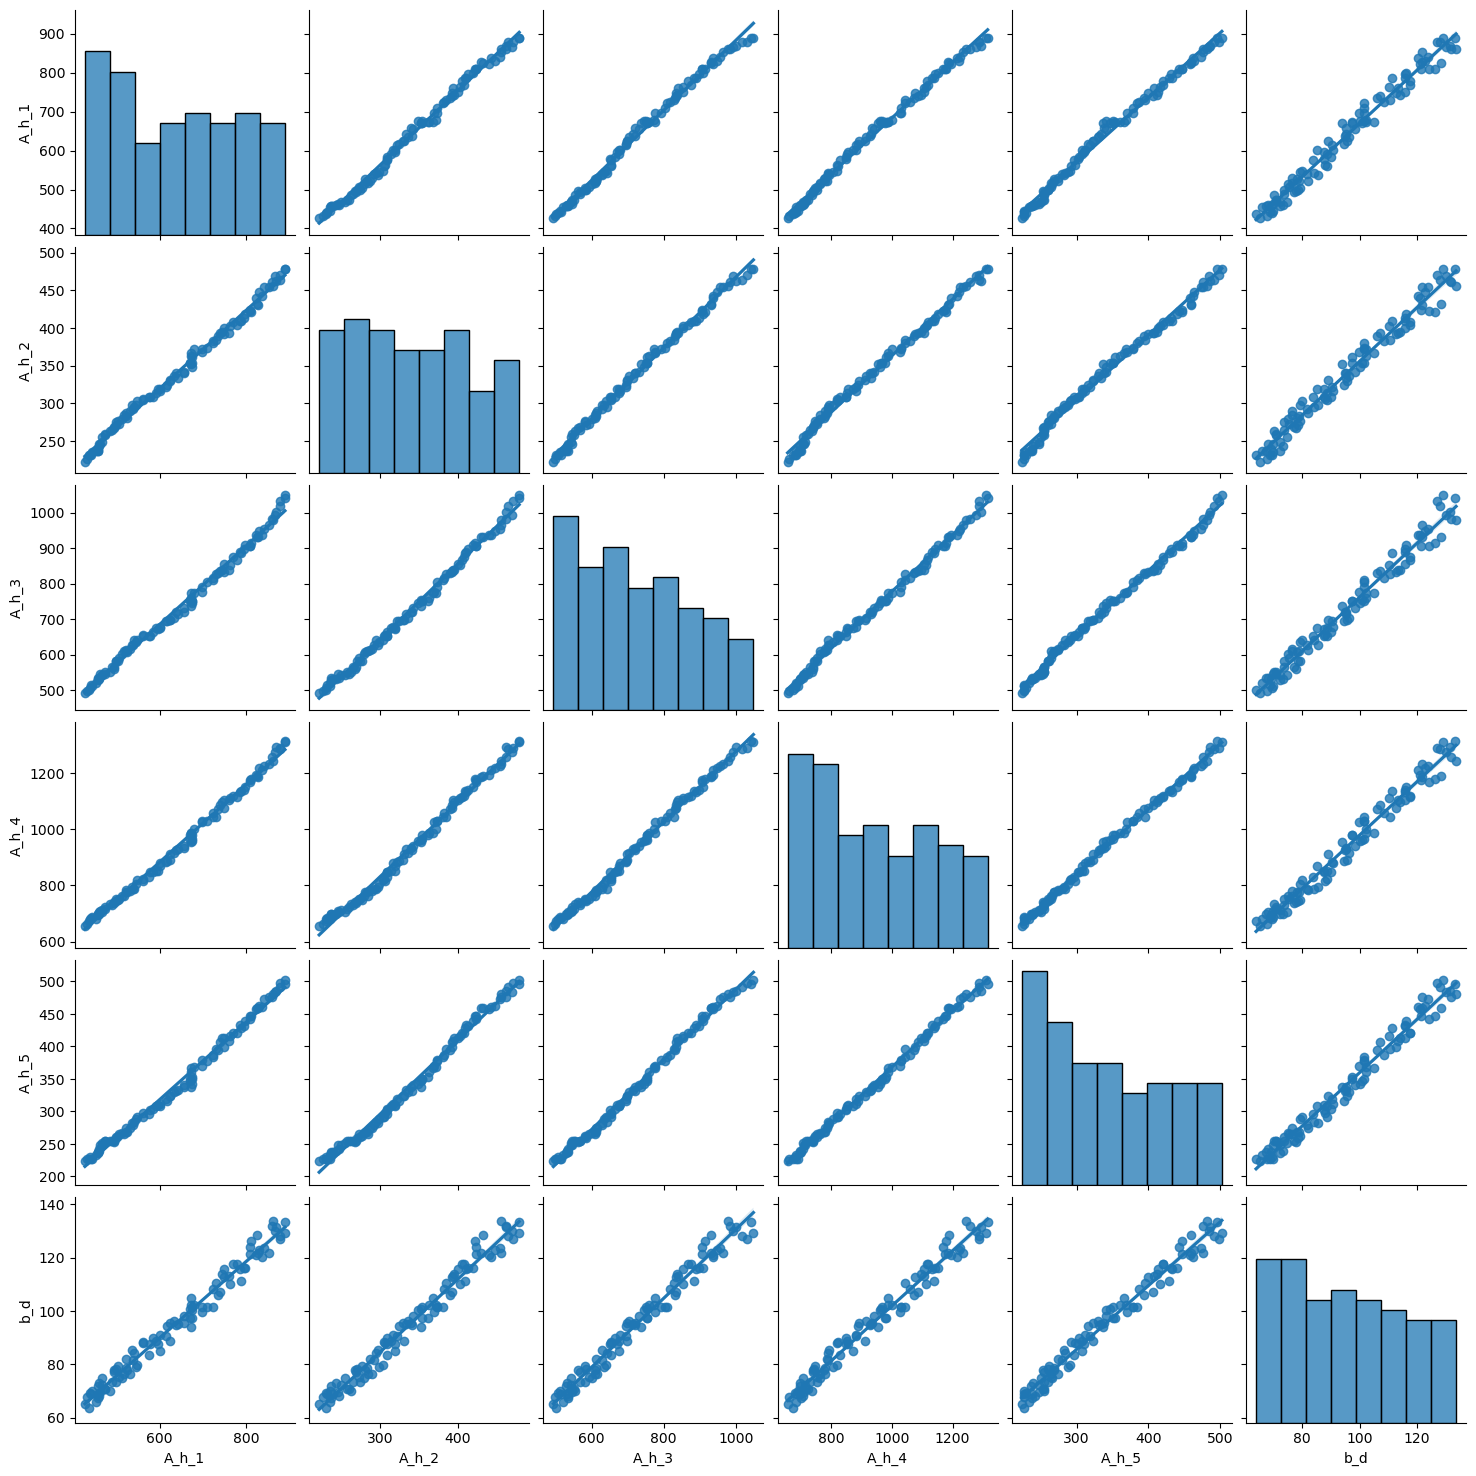

In [31]:
df_modul = df_complex.applymap(lambda x: abs(x))
sns.pairplot(df_modul, kind="reg")
plt.show()

4. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [32]:
A_complex = df_complex.iloc[:, :-1].values
b_complex = df_complex.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex.round(1)}')
print("Определитель матрицы A_complex:", det_A_complex)

Число обусловленности матрицы A_complex: cond(A_complex) = 125512.2
Определитель матрицы A_complex: (-1.58731104949958e+23-2.8097952598019892e+23j)


5. Разбиение на обучающую и тестовые выборки

In [33]:
A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                    b_complex,
                                                                                    test_size=test_size,
                                                                                    random_state=random_seed)

6. Формирование вещественной матрицы A_train признаков и вещественного вектора b_train целевой переменной

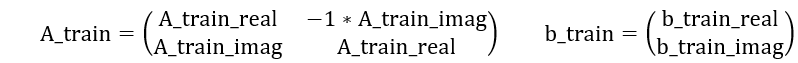


In [34]:
A_train_real = A_train_complex.real
A_train_imag = A_train_complex.imag
A_train_1 = pd.concat([pd.DataFrame(A_train_real), pd.DataFrame(A_train_imag)], axis=0)
A_train_2 = pd.concat([-1 * pd.DataFrame(A_train_imag), pd.DataFrame(A_train_real)], axis=0)
index_train = np.arange(A_train_1.shape[0])
A_train_1.index = index_train
A_train_2.index = index_train 
A_train = pd.merge(A_train_1, A_train_2, left_index=True, right_index=True)
A_train.columns = [f'A_{i+1}' for i in range(A_train.shape[1])]

In [35]:
b_train_real = b_train_complex.real
b_train_imag = b_train_complex.imag
b_train = pd.concat([pd.DataFrame(b_train_real), pd.DataFrame(b_train_imag)], axis=0)
b_train.index = index_train
b_train.columns = ['b']

7. Формирование вещественной матрицы A_test признаков и вещественного вектора b_test целевой переменной

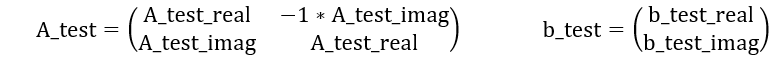

In [36]:
A_test_real = A_test_complex.real
A_test_imag = A_test_complex.imag
A_test_1 = pd.concat([pd.DataFrame(A_test_real), pd.DataFrame(A_test_imag)], axis=0)
A_test_2 = pd.concat([-1 * pd.DataFrame(A_test_imag), pd.DataFrame(A_test_real)], axis=0)
index_test = np.arange(A_test_1.shape[0])
A_test_1.index = index_test
A_test_2.index = index_test 
A_test = pd.merge(A_test_1, A_test_2, left_index=True, right_index=True)
A_test.columns = [f'A_{i+1}' for i in range(A_test.shape[1])]

In [37]:
b_test_real = b_test_complex.real
b_test_imag = b_test_complex.imag
b_test = pd.concat([pd.DataFrame(b_test_real), pd.DataFrame(b_test_imag)], axis=0)
b_test.index = index_test
b_test.columns = ['b']

8. Формирование вещественного вектора A_max для прогноза целевой переменной

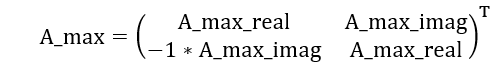

In [38]:
A_max_real = np.array(A_complex_max).real
A_max_imag = np.array(A_complex_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9
0_x,1800.0,1500.0,1800.0,2000.0,1500.0,-1000.0,-1000.0,-1400.0,-1700.0,-1200.0
0_y,1000.0,1000.0,1400.0,1700.0,1200.0,1800.0,1500.0,1800.0,2000.0,1500.0


9. Масштабирование признаков и вектора A_max

In [39]:
sc = MaxAbsScaler()    # MaxAbsScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_train_std = sc.fit_transform(A_train) 
X_test_std = sc.transform(A_test)
# X_train_std = A_train 
# X_test_std = A_test

y_train = b_train
y_test = b_test

In [40]:
A_max_std = sc.transform(A_max)
# A_max_std = A_max
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9
0,2.162,3.506,1.878,1.652,3.339,-1.201,-2.337,-1.460,-1.404,-2.671
1,1.201,2.337,1.460,1.404,2.671,2.162,3.506,1.878,1.652,3.339


10. Обучение моделей регрессоров на train-данных

In [41]:
metrics = {}

10.1 LinearRegression

In [42]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)
b_max_lr = model_lr.predict(A_max_std)[:].flatten().round(3)
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.sqrt(b_max_lr[0]**2 + b_max_lr[1]**2).round(3)
metrics['LinRegr'] = (str(r2_lr_train), str(r2_lr_test), b_max_lr_complex, str(b_max_lr_modul))

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_lr_complex}')
print(f'b max_modul:   {b_max_lr_modul}')
print()
print('Коэффициенты регрессии:')
print(pd.DataFrame(model_lr.coef_.flatten(), columns=['k']).round(3))
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')

RMSE train: 1.941
RMSE test:  2.099

MAE train:  1.699
MAE test:   1.863

R2 train:   0.986
R2 test:    0.986

Прогноз целевой переменной:
b max_complex: (269.211+432.588j)
b max_modul:   509.516

Коэффициенты регрессии:
        k
0  61.928
1  21.600
2 -27.271
3 -54.239
4  91.088
5  32.130
6   9.287
7  -5.286
8 -17.877
9  32.292
Свободный член регрессии  a0 =  [9.968]


10.2 Ridge

In [43]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-7, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)
b_max_rid = model_rid.predict(A_max_std)[:].flatten().round(3)
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.sqrt(b_max_rid[0]**2 + b_max_rid[1]**2).round(3)
metrics['Ridge'] = (str(r2_rid_train), str(r2_rid_test), b_max_rid_complex, str(b_max_rid_modul))

print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_rid_complex}')
print(f'b max_modul:   {b_max_rid_modul}')
model_rid.best_params_

RMSE train: 1.945
RMSE test:  2.065

MAE train:  1.71
MAE test:   1.816

R2 train:   0.986
R2 test:    0.986

Прогноз целевой переменной:
b max_complex: (244.023+408.623j)
b max_modul:   475.941


{'alpha': 0.0007943282347242822, 'random_state': 1}

10.3 Lasso

In [44]:
las = Lasso()
las_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_las = GridSearchCV(estimator=las,
                   param_grid=las_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_las.fit(X_train_std, y_train)

y_las_pred = model_las.predict(X_test_std)
y_las_pred_train = model_las.predict(X_train_std)

rmse_las_train = np.sqrt(mean_squared_error(y_train, y_las_pred_train)).round(3)
rmse_las_test = np.sqrt(mean_squared_error(y_test, y_las_pred)).round(3)
mae_las_train = mean_absolute_error(y_train, y_las_pred_train).round(3)
mae_las_test = mean_absolute_error(y_test, y_las_pred).round(3)
r2_las_train = r2_score(y_train, y_las_pred_train).round(3)
r2_las_test = r2_score(y_test, y_las_pred).round(3)
b_max_las = model_las.predict(A_max_std)[:].flatten().round(3)
b_max_las_complex = complex(b_max_las[0], b_max_las[1])
b_max_las_modul = np.sqrt(b_max_las[0]**2 + b_max_las[1]**2).round(3)
metrics['Lasso'] = (str(r2_las_train), str(r2_las_test), b_max_las_complex, str(b_max_las_modul))

print(f'RMSE train: {rmse_las_train}')
print(f'RMSE test:  {rmse_las_test}')
print()
print(f'MAE train:  {mae_las_train}')
print(f'MAE test:   {mae_las_test}')
print()
print(f'R2 train:   {r2_las_train}')
print(f'R2 test:    {r2_las_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_las_complex}')
print(f'b max_modul:   {b_max_las_modul}')
model_las.best_params_

RMSE train: 1.97
RMSE test:  2.011

MAE train:  1.718
MAE test:   1.754

R2 train:   0.986
R2 test:    0.987

Прогноз целевой переменной:
b max_complex: (222.75+351.743j)
b max_modul:   416.342


{'alpha': 1e-05, 'random_state': 1}

10.4 ElasticNet

In [45]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 3, num=101),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)
b_max_en = model_en.predict(A_max_std).round(3)
b_max_en_complex = complex(b_max_en[0], b_max_en[1])
b_max_en_modul = np.sqrt(b_max_en[0]**2 + b_max_en[1]**2).round(3)
metrics['ElastNet'] = (str(r2_en_train), str(r2_en_test), b_max_en_complex, str(b_max_en_modul))

print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_en_complex}')
print(f'b max_modul:   {b_max_en_modul}')
model_en.best_params_

RMSE train: 1.97
RMSE test:  2.011

MAE train:  1.718
MAE test:   1.752

R2 train:   0.986
R2 test:    0.987

Прогноз целевой переменной:
b max_complex: (222.17+351.54j)
b max_modul:   415.86


{'alpha': 1e-05, 'l1_ratio': 0.9, 'random_state': 1}

10.5 TheilSenRegressor

In [46]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_train_std, y_train)

y_tsr_pred = model_tsr.predict(X_test_std)
y_tsr_pred_train = model_tsr.predict(X_train_std)

rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)
b_max_tsr = model_tsr.predict(A_max_std).round(3)
b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
b_max_tsr_modul = np.sqrt(b_max_tsr[0]**2 + b_max_tsr[1]**2).round(3)
metrics['TheilSen'] = (str(r2_tsr_train), str(r2_tsr_test), b_max_tsr_complex, str(b_max_tsr_modul))

print(f'RMSE train: {rmse_tsr_train}')
print(f'RMSE test:  {rmse_tsr_test}')
print()
print(f'MAE train:  {mae_tsr_train}')
print(f'MAE test:   {mae_tsr_test}')
print()
print(f'R2 train:   {r2_tsr_train}')
print(f'R2 test:    {r2_tsr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_tsr_complex}')
print(f'b max_modul:   {b_max_tsr_modul}')
model_tsr.best_params_

RMSE train: 1.955
RMSE test:  2.04

MAE train:  1.719
MAE test:   1.821

R2 train:   0.986
R2 test:    0.987

Прогноз целевой переменной:
b max_complex: (244.524+412.499j)
b max_modul:   479.528


{'random_state': 1}

11. Средние значения метрик регрессоров и целевой переменной b

In [47]:
r2_train_values = [metrics[key][-4] for key in metrics]
r2_train_values = [float(value) for value in r2_train_values[:-1]]
r2_train_mean = round(sum(r2_train_values) / len(r2_train_values), 3)
r2_test_values = [metrics[key][-3] for key in metrics]
r2_test_values = [float(value) for value in r2_test_values[:-1]]
r2_test_mean = round(sum(r2_test_values) / len(r2_test_values), 3)
b_max_values = [metrics[key][-2] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_real_round = round(b_max_mean.real, 3)
b_max_imag_round = round(b_max_mean.imag, 3)
b_max_mean_complex = complex(b_max_real_round, b_max_imag_round)
b_max_mean_modul = np.sqrt(b_max_real_round**2 + b_max_imag_round**2).round(3)
metrics['Mean'] = (str(r2_train_mean), str(r2_test_mean), b_max_mean_complex, str(b_max_mean_modul))

print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {b_max_mean_complex}')
print(f'b_max_mean_modul: {b_max_mean_modul}')

Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (240.536+391.399j)
b_max_mean_modul: 459.403


12. Определение коэффициента регуляризации alpha методом обобщенной невязки

In [48]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual


X_h = X_train_std
y_d = y_train
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

print(h)
print(d)

# Поиск коэффициента регуляризации alpha
calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
# alpha = newton(calculate_delta_residual_partial, x0=1e-7, tol=1e-7, maxiter=1000)
# alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-7)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

0.21226839972002137
41.5626821899398
Коэффициент регуляризации alpha = 1.34e+01


13. Регуляризированное решение системы уравнений

In [49]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_test_std @ z_hd
y_reg_hd_pred_train = X_train_std @ z_hd

rmse_reg_hd_train = np.sqrt(mean_squared_error(y_train, y_reg_hd_pred_train)).round(3)
rmse_reg_hd_test = np.sqrt(mean_squared_error(y_test, y_reg_hd_pred)).round(3)
mae_reg_hd_train = mean_absolute_error(y_train, y_reg_hd_pred_train).round(3)
mae_reg_hd_test = mean_absolute_error(y_test, y_reg_hd_pred).round(3)
r2_reg_hd_train = r2_score(y_train, y_reg_hd_pred_train).round(3)
r2_reg_hd_test = r2_score(y_test, y_reg_hd_pred).round(3)
b_max_reg_hd = np.dot(np.array(A_max_std), np.array(z_hd)).round(3)
b_max_reg_hd_complex = complex(b_max_reg_hd[0], b_max_reg_hd[1])
b_max_reg_hd_modul = np.sqrt(b_max_reg_hd[0]**2 + b_max_reg_hd[1]**2).round(3)
metrics['Regularized'] = (str(r2_reg_hd_train), str(r2_reg_hd_test), b_max_reg_hd_complex, str(b_max_reg_hd_modul[0]))

print(f'RMSE train: {rmse_reg_hd_train}')
print(f'RMSE test:  {rmse_reg_hd_test}')
print()
print(f'MAE train:  {mae_reg_hd_train}')
print(f'MAE test:   {mae_reg_hd_test}')
print()
print(f'R2 train:   {r2_reg_hd_train}')
print(f'R2 test:    {r2_reg_hd_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b_max_reg_hd_complex: {b_max_reg_hd_complex}')
print(f'b_max_reg_hd_modul:   {b_max_reg_hd_modul[0]}')
print()
z_hd

RMSE train: 4.45
RMSE test:  4.127

MAE train:  3.911
MAE test:   3.612

R2 train:   0.926
R2 test:    0.946

Прогноз целевой переменной:
b_max_reg_hd_complex: (160.093+325.217j)
b_max_reg_hd_modul:   362.486



,b
0,19.747107
1,21.609873
2,20.159957
3,20.256292
4,20.790438
5,12.354575
6,10.551369
7,11.005677
8,11.681771
9,10.153560


In [50]:
# N_feat = X_h.shape[1]

# print("Точные масштабированные коэффициенты регрессии:")
# for i in range(0, N_feat): 
#     print((np.array(z_complex_acc)[i] * np.amax(A[:, i])).round(2))
# print()
# print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
# print("Регуляризованные масштабированные коэффициенты регрессии:")
# for i in range(0, N_feat): 
#     print(z_hd[i].round(2))

14. Точный прогноз целевой переменной b

In [51]:
b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_complex_acc)).round(3)
b_max_acc_modul = abs(b_max_acc_complex).round(3)
metrics['Accurate'] = ('', '', b_max_acc_complex[0], b_max_acc_modul[0])

print(f'Точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex[0]}')
print(f'b_max_acc_modul: {b_max_acc_modul[0]}')

Точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (147.1+303.7j)
b_max_acc_modul: 337.449


15. Сводная таблица метрик и прогнозов моделей

In [52]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul']
df_metrics = df_metrics.astype(object)
df_metrics

,LinRegr,Ridge,Lasso,ElastNet,TheilSen,Mean,Regularized,Accurate
R2 train,0.986,0.986,0.986,0.986,0.986,0.986,0.926,
R2 test,0.986,0.986,0.987,0.987,0.987,0.987,0.946,
b_max_complex,(269.211+432.588j),(244.023+408.623j),(222.75+351.743j),(222.17+351.54j),(244.524+412.499j),(240.536+391.399j),(160.093+325.217j),(147.1+303.7j)
b_max_modul,509.516,475.941,416.342,415.86,479.528,459.403,362.486,337.449
